In [1]:
import os
import requests
import pandas as pd
import numpy as np

# URL and API Key of Alpha Vantage
url = 'https://www.alphavantage.co/query?'

api_key = os.getenv('ALPHA_VANTAGE_API_KEY')

params = {
    'function': 'TIME_SERIES_DAILY',
    'symbol': 'TSLA',
    'outputsize': 'full',
    'datatype': 'csv',
    'apikey': api_key
}

headers = {
}

In [2]:
print(api_key)

UL5CJJGFRPG14MGK


In [3]:
# url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&apikey=UL5CJJGFRPG14MGK&datatype=csv&outputsize=full"

# payload = {}
# headers = {
#   'ALPHA_VANTAGE_API_KEY': 'UL5CJJGFRPG14MGK'
# }

response = requests.request("GET", url, params=params, headers=headers)

print(response.text)

timestamp,open,high,low,close,volume
2023-09-01,257.2600,259.0794,242.0100,245.0100,132541640
2023-08-31,255.9800,261.1800,255.0500,258.0800,108861698
2023-08-30,254.2000,260.5100,250.5900,256.9000,121988437
2023-08-29,238.5800,257.4800,237.7700,257.1800,134047603
2023-08-28,242.5800,244.3800,235.3500,238.8200,107673727
2023-08-25,231.3100,239.0000,230.3500,238.5900,106612231
2023-08-24,238.6600,238.9200,228.1801,230.0400,99777432
2023-08-23,229.3400,238.9800,229.2900,236.8600,101077635
2023-08-22,240.2500,240.8200,229.5500,233.1900,130597886
2023-08-21,221.5512,232.1343,220.5800,231.2800,135702671
2023-08-18,214.1200,217.5800,212.3600,215.4900,136276584
2023-08-17,226.0600,226.7400,218.8300,219.2200,120718417
2023-08-16,228.0200,233.9700,225.3800,225.6000,112484520
2023-08-15,238.7300,240.5000,232.6100,232.9600,88197599
2023-08-14,235.7000,240.6600,233.7500,239.7600,98595331
2023-08-11,241.7700,243.7900,238.0200,242.6500,99038642
2023-08-10,245.4000,251.8000,243.0000,245.3400,10949860

In [4]:
# Transforming the content of the request to a dataframe.
request_content = response.content
data = list(map(lambda x: x.split(','),request_content.decode('utf-8').split("\r\n")))
print(data)
df = pd.DataFrame(data[1:], columns=data[0])
#df = df.set_index('timestamp')
#df.index = pd.to_datetime(df.index)
df.head()

[['timestamp', 'open', 'high', 'low', 'close', 'volume'], ['2023-09-01', '257.2600', '259.0794', '242.0100', '245.0100', '132541640'], ['2023-08-31', '255.9800', '261.1800', '255.0500', '258.0800', '108861698'], ['2023-08-30', '254.2000', '260.5100', '250.5900', '256.9000', '121988437'], ['2023-08-29', '238.5800', '257.4800', '237.7700', '257.1800', '134047603'], ['2023-08-28', '242.5800', '244.3800', '235.3500', '238.8200', '107673727'], ['2023-08-25', '231.3100', '239.0000', '230.3500', '238.5900', '106612231'], ['2023-08-24', '238.6600', '238.9200', '228.1801', '230.0400', '99777432'], ['2023-08-23', '229.3400', '238.9800', '229.2900', '236.8600', '101077635'], ['2023-08-22', '240.2500', '240.8200', '229.5500', '233.1900', '130597886'], ['2023-08-21', '221.5512', '232.1343', '220.5800', '231.2800', '135702671'], ['2023-08-18', '214.1200', '217.5800', '212.3600', '215.4900', '136276584'], ['2023-08-17', '226.0600', '226.7400', '218.8300', '219.2200', '120718417'], ['2023-08-16', '228

,timestamp,open,high,low,close,volume
0,2023-09-01,257.2600,259.0794,242.0100,245.0100,132541640
1,2023-08-31,255.9800,261.1800,255.0500,258.0800,108861698
2,2023-08-30,254.2000,260.5100,250.5900,256.9000,121988437
3,2023-08-29,238.5800,257.4800,237.7700,257.1800,134047603
4,2023-08-28,242.5800,244.3800,235.3500,238.8200,107673727


In [5]:
num_cols = ['open', 'high', 'low', 'close', 'volume']

for col in num_cols:  
    df[col] = df[col].astype('float')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3319 entries, 0 to 3318
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  3319 non-null   object 
 1   open       3318 non-null   float64
 2   high       3318 non-null   float64
 3   low        3318 non-null   float64
 4   close      3318 non-null   float64
 5   volume     3318 non-null   float64
dtypes: float64(5), object(1)
memory usage: 155.7+ KB


In [7]:
df.describe()

,open,high,low,close,volume
count,3318.000000,3318.000000,3318.000000,3318.000000,3.318000e+03
mean,309.723075,316.478114,302.622851,309.786109,1.947140e+07
std,294.998831,302.966188,286.695506,295.198297,3.612379e+07
min,16.140000,16.630000,14.980000,15.800000,1.185000e+05
25%,142.008750,145.670000,138.672500,142.452500,3.099012e+06
50%,234.260000,237.890000,229.440000,233.635000,6.472279e+06
75%,342.270000,348.162500,336.050000,342.707500,1.794548e+07
max,2295.120000,2318.490000,2186.520000,2238.750000,3.065906e+08


In [8]:
df = df.rename(columns={'timestamp': 'date'})

In [9]:
# Reindex data using a DatetimeIndex
df.set_index(pd.DatetimeIndex(df['date']), inplace=True)

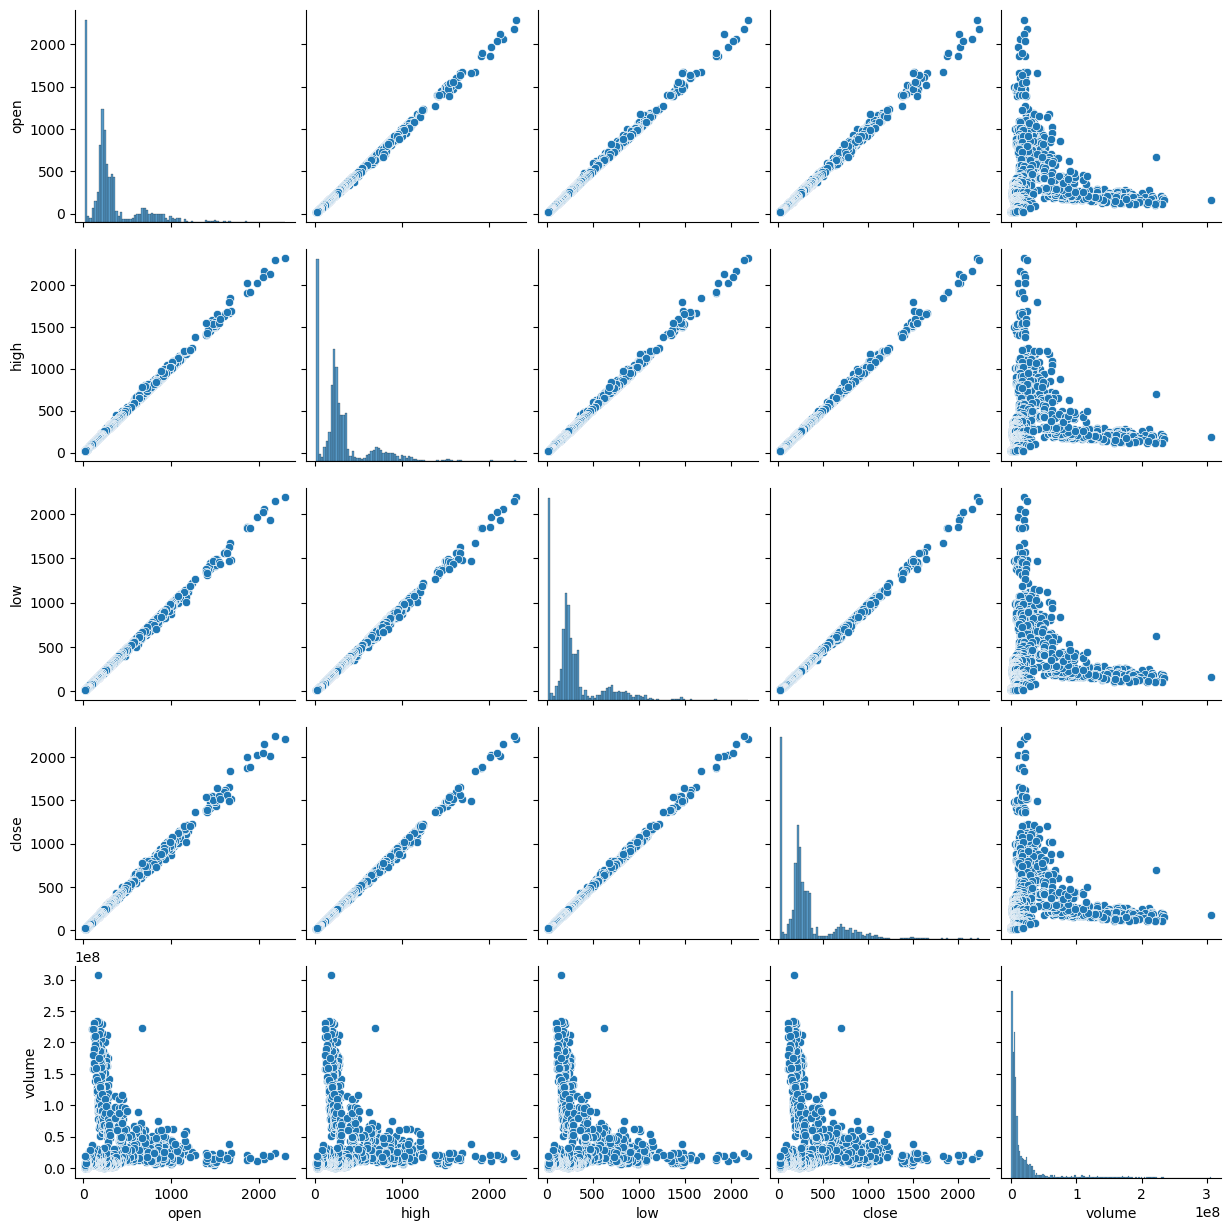

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df)

In [11]:
# For plotting candlestick charts.
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])
# fig.show()
fig.show()

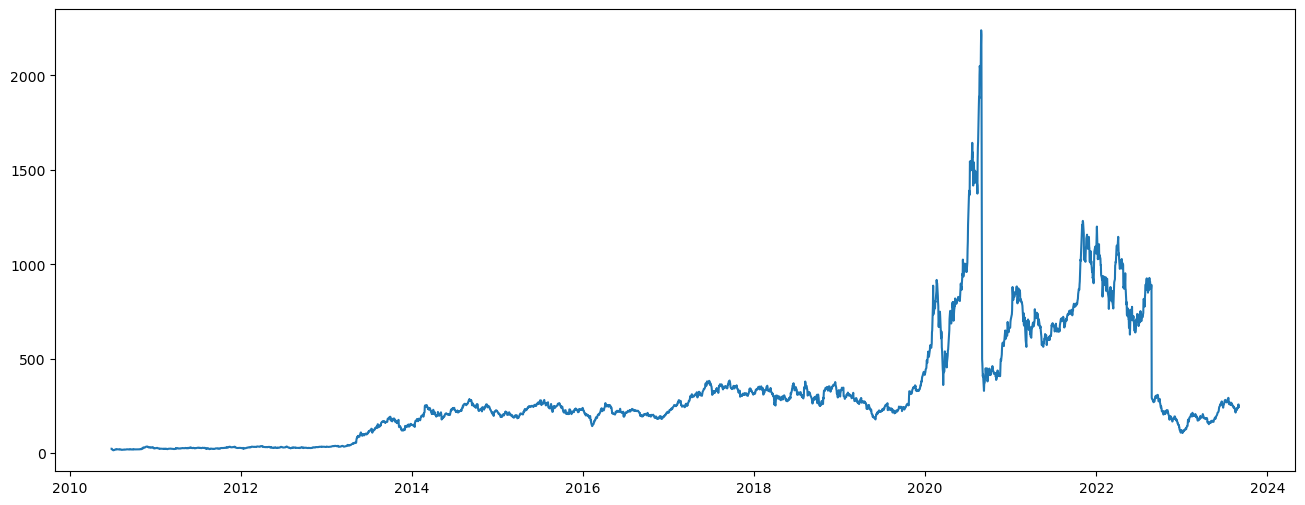

In [12]:
# Plotting the time series.
plt.figure(figsize=(16,6))
plt.plot(df['close'])
plt.show()

In [13]:
df.isnull().sum()

date      0
open      1
high      1
low       1
close     1
volume    1
dtype: int64

In [14]:
df = df.dropna()

### Decompose Time Series Data into Trend and Seasonality

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

<Figure size 640x480 with 0 Axes>

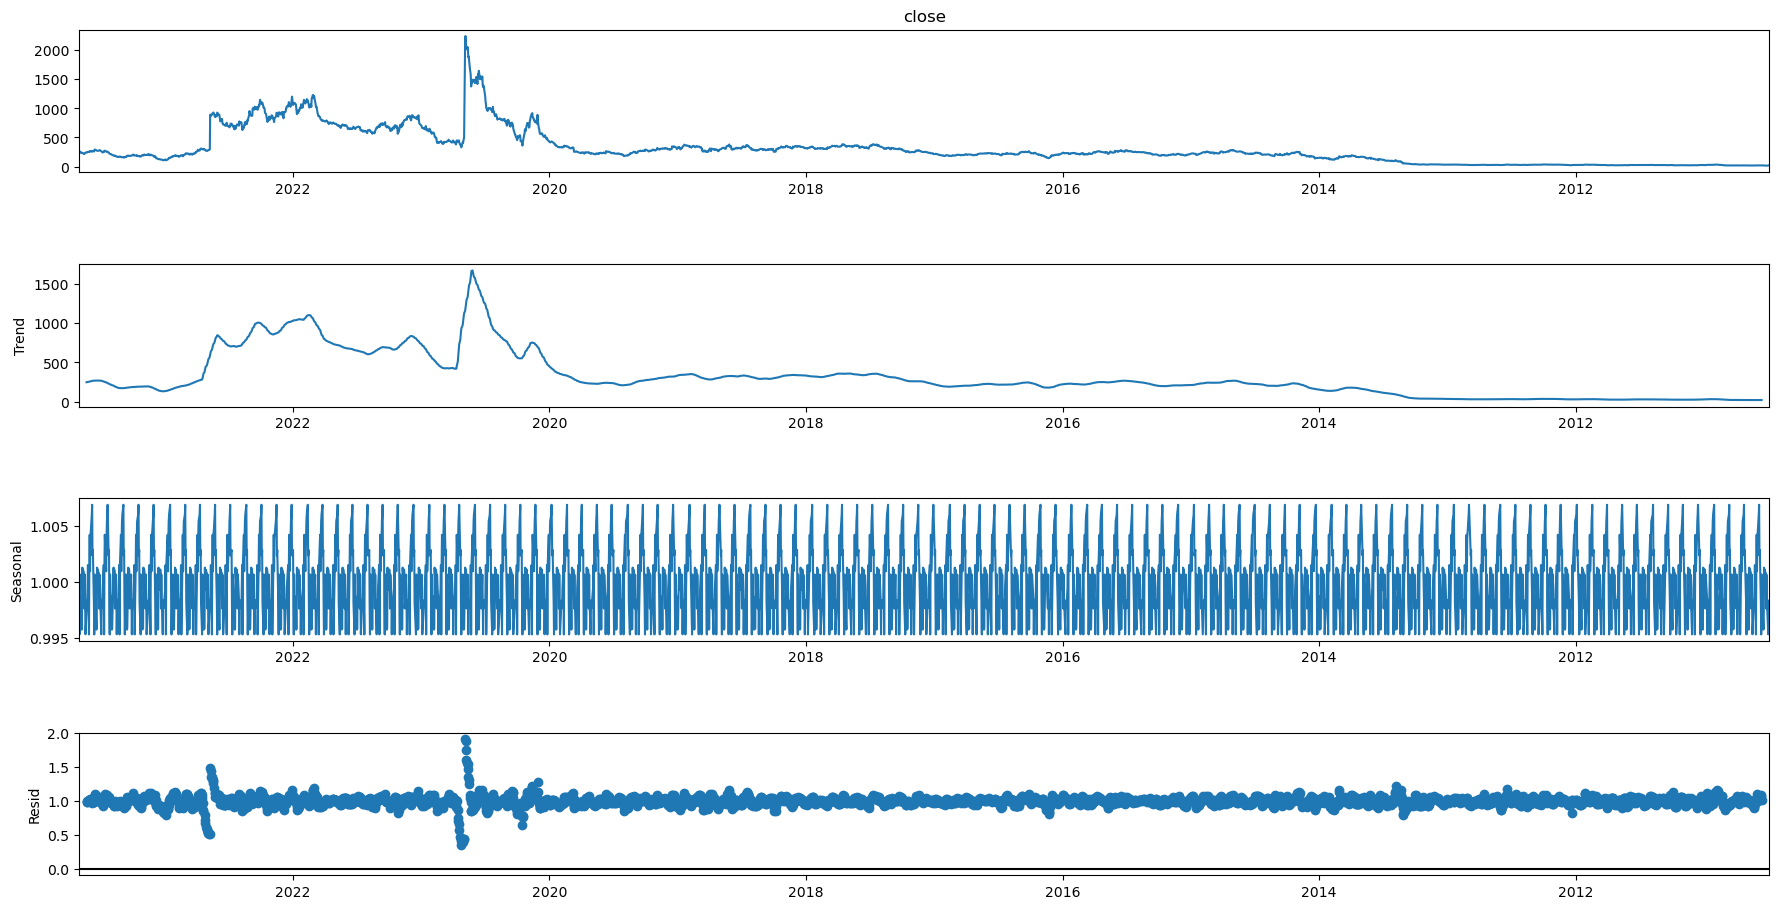

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Checking decomposition of trend, seasonality and residue of the original time seires.
decomposition = seasonal_decompose(df['close'], model='multiplicative', period=30)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)

In [16]:
import pandas_ta
# Add EMA to dataframe by appending
# Note: pandas_ta integrates seamlessly into
# our existing dataframe
df.ta.ema(close='close', length=10, append=True)


C:\Users\thong.lam\AppData\Local\Temp\ipykernel_21564\2484878180.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



date
2023-09-01          NaN
2023-08-31          NaN
2023-08-30          NaN
2023-08-29          NaN
2023-08-28          NaN
                ...    
2010-07-06    17.874895
2010-07-02    18.115823
2010-07-01    18.814765
2010-06-30    19.726626
2010-06-29    20.483603
Name: EMA_10, Length: 3318, dtype: float64

In [17]:
df

,date,open,high,low,close,volume,EMA_10
date,,,,,,,
2023-09-01,2023-09-01,257.26,259.0794,242.01,245.01,132541640.0,NaN
2023-08-31,2023-08-31,255.98,261.1800,255.05,258.08,108861698.0,NaN
2023-08-30,2023-08-30,254.20,260.5100,250.59,256.90,121988437.0,NaN
2023-08-29,2023-08-29,238.58,257.4800,237.77,257.18,134047603.0,NaN
2023-08-28,2023-08-28,242.58,244.3800,235.35,238.82,107673727.0,NaN
...,...,...,...,...,...,...,...
2010-07-06,2010-07-06,20.00,20.0000,15.83,16.11,6866900.0,17.874895
2010-07-02,2010-07-02,23.00,23.1000,18.71,19.20,5139800.0,18.115823
2010-07-01,2010-07-01,25.00,25.9200,20.27,21.96,8218800.0,18.814765


In [18]:
# Drop the first n-rows
df = df.iloc[10:]

# View our newly-formed dataset
print(df.head(10))

                  date    open      high     low   close       volume  \
date                                                                    
2023-08-18  2023-08-18  214.12  217.5800  212.36  215.49  136276584.0   
2023-08-17  2023-08-17  226.06  226.7400  218.83  219.22  120718417.0   
2023-08-16  2023-08-16  228.02  233.9700  225.38  225.60  112484520.0   
2023-08-15  2023-08-15  238.73  240.5000  232.61  232.96   88197599.0   
2023-08-14  2023-08-14  235.70  240.6600  233.75  239.76   98595331.0   
2023-08-11  2023-08-11  241.77  243.7900  238.02  242.65   99038642.0   
2023-08-10  2023-08-10  245.40  251.8000  243.00  245.34  109498608.0   
2023-08-09  2023-08-09  250.87  251.1000  241.90  242.19  101596324.0   
2023-08-08  2023-08-08  247.45  250.9200  245.01  249.70   96642183.0   
2023-08-07  2023-08-07  251.45  253.6511  242.76  251.45  111097943.0   

                EMA_10  
date                    
2023-08-18  237.666818  
2023-08-17  234.312851  
2023-08-16  232.728696 

In [19]:
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
EMA_10    0
dtype: int64

In [20]:
df = df.dropna()

In [21]:
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
EMA_10    0
dtype: int64

Test Train Split

In [22]:
# Select X and y
X = df[['close']]
y = df[['EMA_10']]

In [23]:
print(X.shape)
print(y.shape)

(3308, 1)
(3308, 1)


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [25]:
print(X_test.describe())

             close
count   662.000000
mean    303.783569
std     297.677132
min      15.800000
25%     132.160000
50%     231.865000
75%     335.287500
max    2213.400000


In [26]:
print(X_train.describe())

             close
count  2646.000000
mean    311.541813
std     295.139937
min      16.110000
25%     144.025000
50%     233.995000
75%     345.065000
max    2238.750000


Train the Model

In [27]:
from sklearn.linear_model import LinearRegression

# Create Regression Model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Use model to make predictions
y_pred = model.predict(X_test)

Validating the Fit

In [28]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Coefficient of Determination:", r2_score(y_test, y_pred))

Mean Absolute Error: 17.261778917560083
Coefficient of Determination: 0.9520376766785579


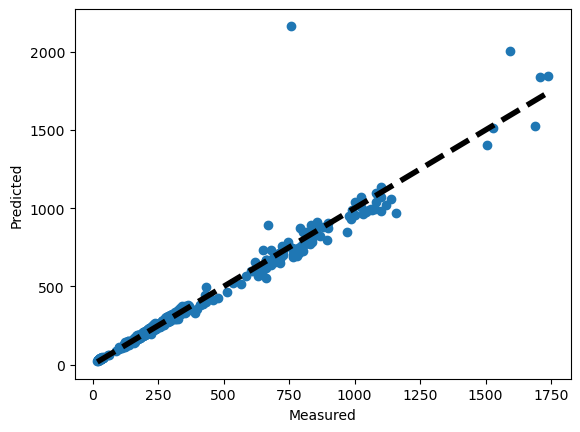

In [29]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Interpretation

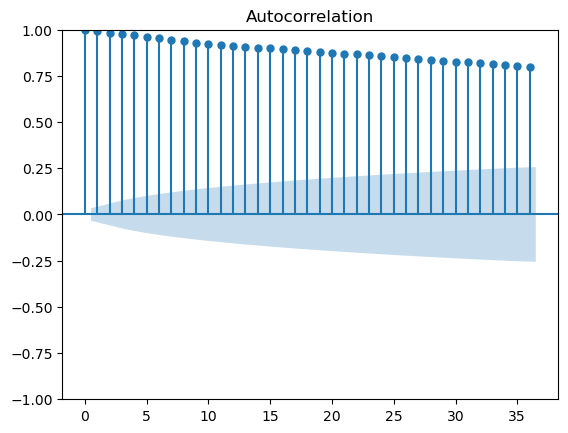

In [30]:
from statsmodels.graphics.tsaplots import plot_acf

df_arima = df[['date', 'close']].set_index(['date'])
df_arima = df_arima.dropna()

plot_acf(df_arima)

plt.show()

In [31]:
df_arima.isnull().sum()

close    0
dtype: int64

## Part 1: Ways to get data from source

- Alpha Vantage API
- Yahoo Finance

In [32]:
import yfinance as yf
from datetime import datetime

symbol = "TSLA"
symbol_name = yf.Ticker(symbol)

In [33]:
# Get data of 10 recent years
df = yf.download(symbol, period='10y')

# Save the data to CSV file
df.to_csv('data/' + symbol + '.csv')

[*********************100%%**********************]  1 of 1 completed


In [34]:
# Loading data from CSV file
df = pd.read_csv('data/' + symbol + '.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-09-05,11.340000,11.433333,11.216667,11.328667,11.328667,100279500
1,2013-09-06,11.238000,11.313333,11.010000,11.131333,11.131333,129295500
2,2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500
3,2013-09-10,10.763333,11.166667,10.708667,11.091333,11.091333,134517000
4,2013-09-11,11.094000,11.193333,10.808667,10.901333,10.901333,87487500


In [35]:
# Change column names to lower case to process easier
df.columns = df.columns.str.lower()

## Part 2: EDA

#### Handle missing values


In [36]:
df.isnull().sum()

date         0
open         0
high         0
low          0
close        0
adj close    0
volume       0
dtype: int64

Note:
- No missing values

Handle duplicated values

In [37]:
duplicated_rows = df.duplicated().sum()
duplicated_rows

0

Note:
- No duplicated values

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       2517 non-null   object 
 1   open       2517 non-null   float64
 2   high       2517 non-null   float64
 3   low        2517 non-null   float64
 4   close      2517 non-null   float64
 5   adj close  2517 non-null   float64
 6   volume     2517 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.8+ KB


In [51]:
num_feats = ['open', 'high', 'low', 'close', 'adj close', 'volume']

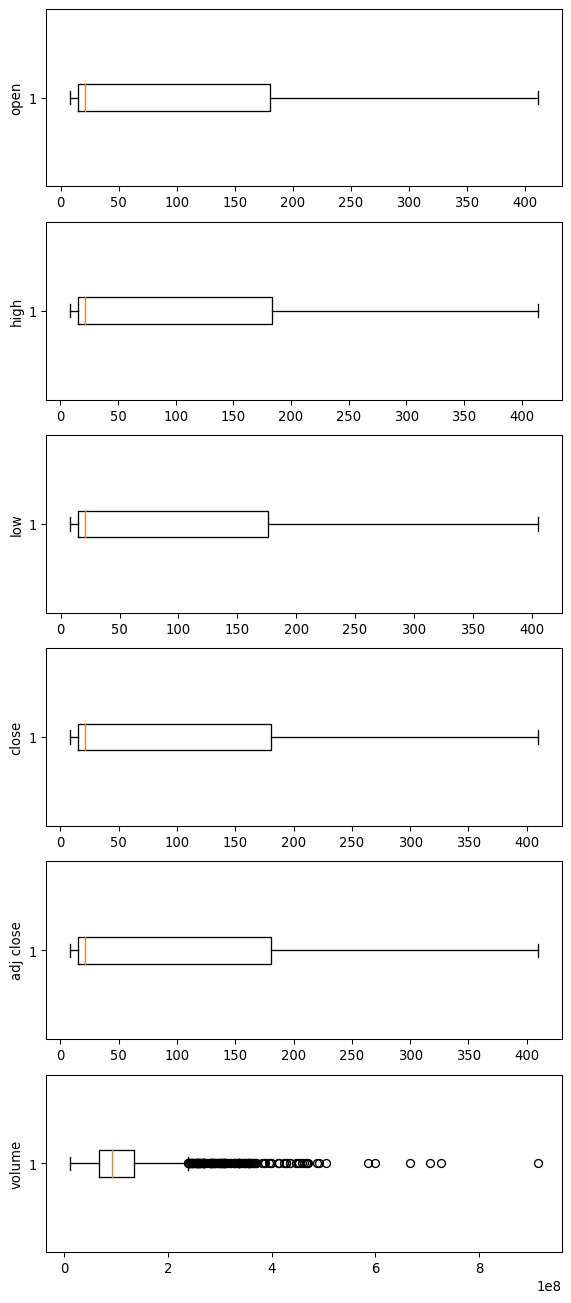

In [52]:
# Box Plots
fig, axs = plt.subplots(len(num_feats),1,dpi=95, figsize=(7,17))
i = 0
for col in num_feats:
    axs[i].boxplot(df[col], vert=False)
    axs[i].set_ylabel(col)
    i+=1

plt.show()

In [54]:
# Reindex data using a DatetimeIndex
# df.set_index(pd.DatetimeIndex(df['date']), inplace=True)

In [53]:
df

,open,high,low,close,adj close,volume
date,,,,,,
2013-09-05,11.340000,11.433333,11.216667,11.328667,11.328667,100279500
2013-09-06,11.238000,11.313333,11.010000,11.131333,11.131333,129295500
2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500
2013-09-10,10.763333,11.166667,10.708667,11.091333,11.091333,134517000
2013-09-11,11.094000,11.193333,10.808667,10.901333,10.901333,87487500
...,...,...,...,...,...,...
2023-08-29,238.580002,257.480011,237.770004,257.179993,257.179993,134047600
2023-08-30,254.199997,260.510010,250.589996,256.899994,256.899994,121988400
2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2013-09-05 to 2023-09-05
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      2517 non-null   int64  
 1   date       2517 non-null   object 
 2   open       2517 non-null   float64
 3   high       2517 non-null   float64
 4   low        2517 non-null   float64
 5   close      2517 non-null   float64
 6   adj close  2517 non-null   float64
 7   volume     2517 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 177.0+ KB


In [55]:
df.describe()

,open,high,low,close,adj close,volume
count,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03
mean,86.611801,88.548045,84.522316,86.587104,86.587104,1.147265e+08
std,106.033741,108.448601,103.356062,105.937536,105.937536,7.731264e+07
min,7.958667,8.181333,7.740000,8.033333,8.033333,1.062000e+07
25%,15.329333,15.557333,15.068667,15.324667,15.324667,6.643230e+07
50%,20.926001,21.236668,20.587334,20.982668,20.982668,9.288270e+07
75%,179.940002,183.809998,176.110001,180.449997,180.449997,1.353465e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [56]:
# Function to detect outliers
def detect_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = dataframe[(dataframe[column] < Q1 - 1.5*IQR) | (dataframe[column] > Q3 + 1.5*IQR)]
    return outliers

# Detect and print number of outliers for each feature
#for column in df.columns:
for column in num_feats:
    outliers = detect_outliers(df, column)
    print(f'Number of outliers in {column}: {len(outliers)}')

Number of outliers in open: 0
Number of outliers in high: 0
Number of outliers in low: 0
Number of outliers in close: 0
Number of outliers in adj close: 0
Number of outliers in volume: 174


In [57]:
def handle_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    dataframe[column] = dataframe[column].apply(lambda x: upper_limit if x > upper_limit else lower_limit if x < lower_limit else x)

# Handle outliers for each feature
#for column in df.columns:
for column in num_feats:
    handle_outliers(df, column)

In [58]:
for column in num_feats:
    outliers = detect_outliers(df, column)
    print(f'Number of outliers in {column}: {len(outliers)}')

Number of outliers in open: 0
Number of outliers in high: 0
Number of outliers in low: 0
Number of outliers in close: 0
Number of outliers in adj close: 0
Number of outliers in volume: 0


## Part 3. Price Prediction using Regression

In [60]:
df['100ma']=df['adj close'].rolling(window=100,min_periods=0).mean()

<BarContainer object of 2517 artists>

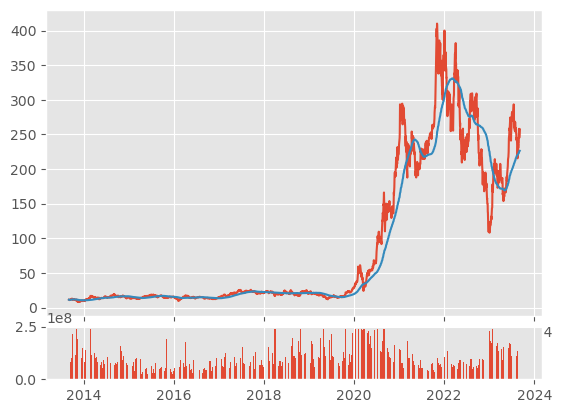

In [62]:
from matplotlib import style
style.use('ggplot')

ax1= plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax2= plt.subplot2grid((6,1),(5,0),rowspan=1,colspan=1,sharex=ax1)
ax1.plot(df.index,df['adj close'])
ax1.plot(df.index,df['100ma'])
ax2.bar(df.index,df['volume'])

In [63]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# # Creating figure with second y-axis
# fig = make_subplots(specs=[[{"secondary_y": True}]])

# # Adding line plot with close prices and bar plot with trading volume
# fig.add_trace(go.Scatter(x=df.index, y=df['adj close'], name='Close'), secondary_y=False)
# fig.add_trace(go.Bar(x=df.index, y=df['volume'], name='Volume', opacity=0.5), secondary_y=True)

# # Updating layout
# fig.update_layout(
#     title='Close Prices',
#     xaxis_title='date',
#     yaxis_title='price',
#     template='plotly_white',
#     xaxis_rangeslider_visible=True,
#     hovermode='x'
# )

# # Disabling grid of second y-axis
# fig.layout.yaxis2.showgrid=False

# # Showing figure
# fig.show()

## Feature Engineering

In [64]:
# Create a Data Frame for regression model
dfreg = df.loc[:,['adj close','volume']]
dfreg['hl_pct'] = (df['high'] - df['low']) / df['close'] * 100.0
dfreg['hct_change'] = (df['close'] - df['open']) / df['open'] * 100.0
dfreg.head()

,adj close,volume,hl_pct,hct_change
date,,,,
2013-09-05,11.328667,100279500.0,1.912548,-0.099942
2013-09-06,11.131333,129295500.0,2.725031,-0.949160
2013-09-09,10.713333,215167500.0,3.727448,-1.483577
2013-09-10,11.091333,134517000.0,4.129352,3.047384
2013-09-11,10.901333,87487500.0,3.528610,-1.736678


### Pre-processing & Cross Validation

Drop missing value

Separating the label here, we want to predict the AdjClose

Scale the X so that everyone can have the same distribution for linear regression

Finally We want to find Data Series of late X and early X (train) for model generation and evaluation

Separate label and identify it as y

Separation of training and testing of model by cross validation train test split

In [65]:
import math
import numpy as np
from sklearn import preprocessing, svm


# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

print(dfreg.shape)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the adjclose
forecast_col = 'adj close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)

(2517, 4)
Dimension of X (2491, 4)
Dimension of y (2491,)


C:\Users\thong.lam\AppData\Local\Temp\ipykernel_21564\1736694228.py:16: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:247: UserWarning:

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.



In [66]:
from sklearn.model_selection import train_test_split
# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Model Generation

To predict the return of the stocks in the next period - Prediction analysis

- Simple Linear Analysis
- Quadratic Linear Analysis (QDA)
- K Nearest Neighbor (KNN

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)


# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)
    
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [68]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

print("The linear regression confidence is ",confidencereg)
print("The quadratic regression 2 confidence is ",confidencepoly2)
print("The quadratic regression 3 confidence is ",confidencepoly3)
print("The knn regression confidence is ",confidenceknn)

The linear regression confidence is  0.9303712689352546
The quadratic regression 2 confidence is  0.9426617066926288
The quadratic regression 3 confidence is  0.9431837495941686
The knn regression confidence is  0.906544884622478


In [69]:
# Printing the forecast
# using Linear Regression
# It should be better to use the most confidence one
forecast_set = clfreg.predict(X_lately)
dfreg['forecast'] = np.nan
print(forecast_set, confidencereg, forecast_out)

[263.99125846 257.23821197 251.18026116 256.32811609 249.73145936
 248.78711516 247.52642547 239.20038831 243.32398133 240.82103554
 237.65378897 229.48280549 224.14378232 218.69268086 217.56394059
 231.00596366 232.1130119  234.14191756 226.50378707 236.67522595
 236.5757116  254.04173918 255.47172022 256.70823647 241.87169339
 254.72664383] 0.9303712689352546 26


## Plotting the Prediction

In [70]:
from datetime import datetime as dt, timedelta

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

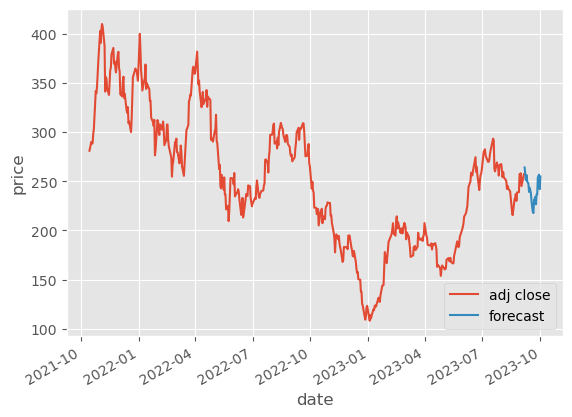

In [71]:
dfreg['adj close'].tail(500).plot()
dfreg['forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('date')
plt.ylabel('price')
plt.show()

## Part 4. Prediction Using LSTM : A Time-Series model

In [ ]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df

,date,open,high,low,close,adj close,volume
date,,,,,,,
2013-09-03,2013-09-03,11.560000,11.580000,11.093333,11.262667,11.262667,180916500.0
2013-09-04,2013-09-04,11.318000,11.441333,11.037333,11.374667,11.374667,172135500.0
2013-09-05,2013-09-05,11.340000,11.433333,11.216667,11.328667,11.328667,100279500.0
2013-09-06,2013-09-06,11.238000,11.313333,11.010000,11.131333,11.131333,129295500.0
2013-09-09,2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500.0
...,...,...,...,...,...,...,...
2023-08-28,2023-08-28,242.580002,244.380005,235.350006,238.820007,238.820007,107673700.0
2023-08-29,2023-08-29,238.580002,257.480011,237.770004,257.179993,257.179993,134047600.0
2023-08-30,2023-08-30,254.199997,260.510010,250.589996,256.899994,256.899994,121988400.0


#### Data Visualization

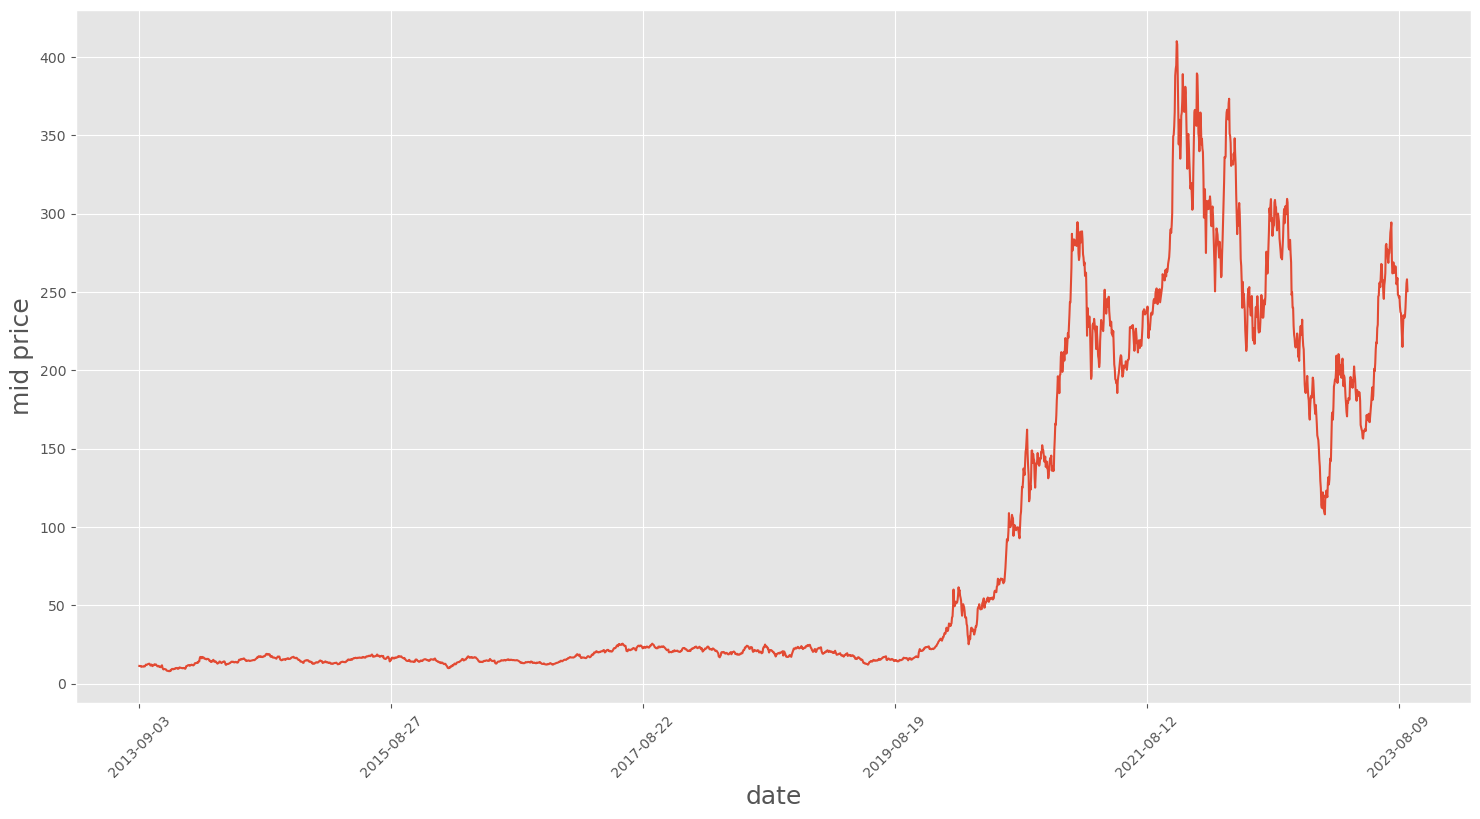

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['date'].loc[::500],rotation=45)
plt.xlabel('date',fontsize=18)
plt.ylabel('mid price',fontsize=18)
plt.show()

Splitting Data into a Training set and a Test set

In [ ]:
# First calculate the mid prices from the highest and lowest
# high_prices = df.loc[:,'High'].as_matrix()
# low_prices = df.loc[:,'Low'].as_matrix()
# as_matrix() was depreciated after version 0.23.0. Use df.values instead
high_prices = df.loc[:,'high'].values
low_prices = df.loc[:,'low'].values
mid_prices = (high_prices+low_prices)/2.0

In [ ]:
len(mid_prices)

2518

In [ ]:
train_data = mid_prices[:2100]
test_data = mid_prices[2100:]

Normalizing the Data

In [ ]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [ ]:
# Train the Scaler with training data and smooth data
# 1500 + 600 = 2100 (train-data-size)
smoothing_window_size = 600
for di in range(0,1500,smoothing_window_size):
    # print(di)
    # print(di+smoothing_window_size)
    # # print(train_data[di:di+smoothing_window_size,:])
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [ ]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [ ]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(2100):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

One-Step Ahead Prediction via Averaging

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df

,date,open,high,low,close,adj close,volume
0,2013-09-03,11.560000,11.580000,11.093333,11.262667,11.262667,180916500.0
1,2013-09-04,11.318000,11.441333,11.037333,11.374667,11.374667,172135500.0
2,2013-09-05,11.340000,11.433333,11.216667,11.328667,11.328667,100279500.0
3,2013-09-06,11.238000,11.313333,11.010000,11.131333,11.131333,129295500.0
4,2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500.0
...,...,...,...,...,...,...,...
2513,2023-08-28,242.580002,244.380005,235.350006,238.820007,238.820007,107673700.0
2514,2023-08-29,238.580002,257.480011,237.770004,257.179993,257.179993,134047600.0
2515,2023-08-30,254.199997,260.510010,250.589996,256.899994,256.899994,121988400.0
2516,2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700.0


In [ ]:
df.loc[100,'date']

'2014-01-27'

In [ ]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.01633


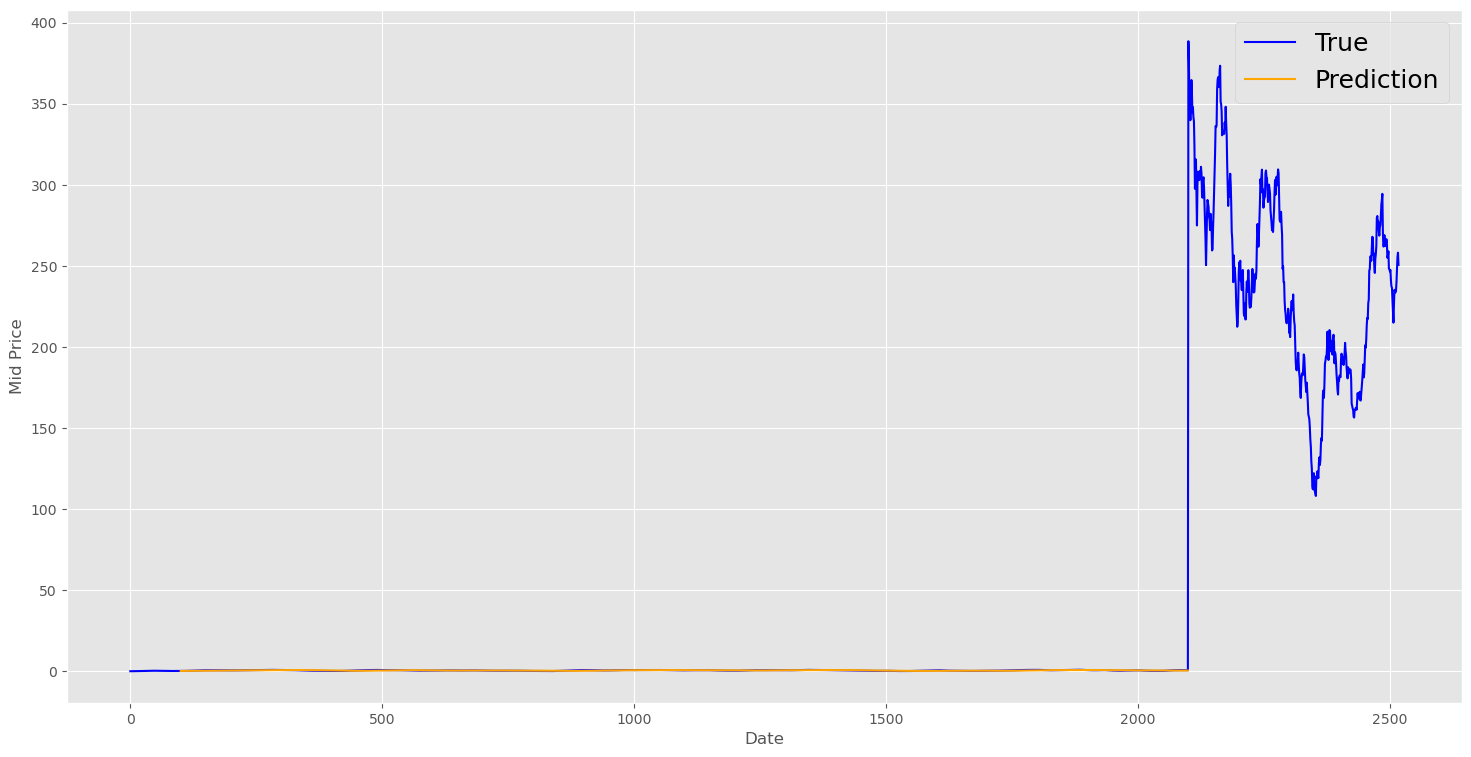

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

Exponential Moving Average

In [ ]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00010


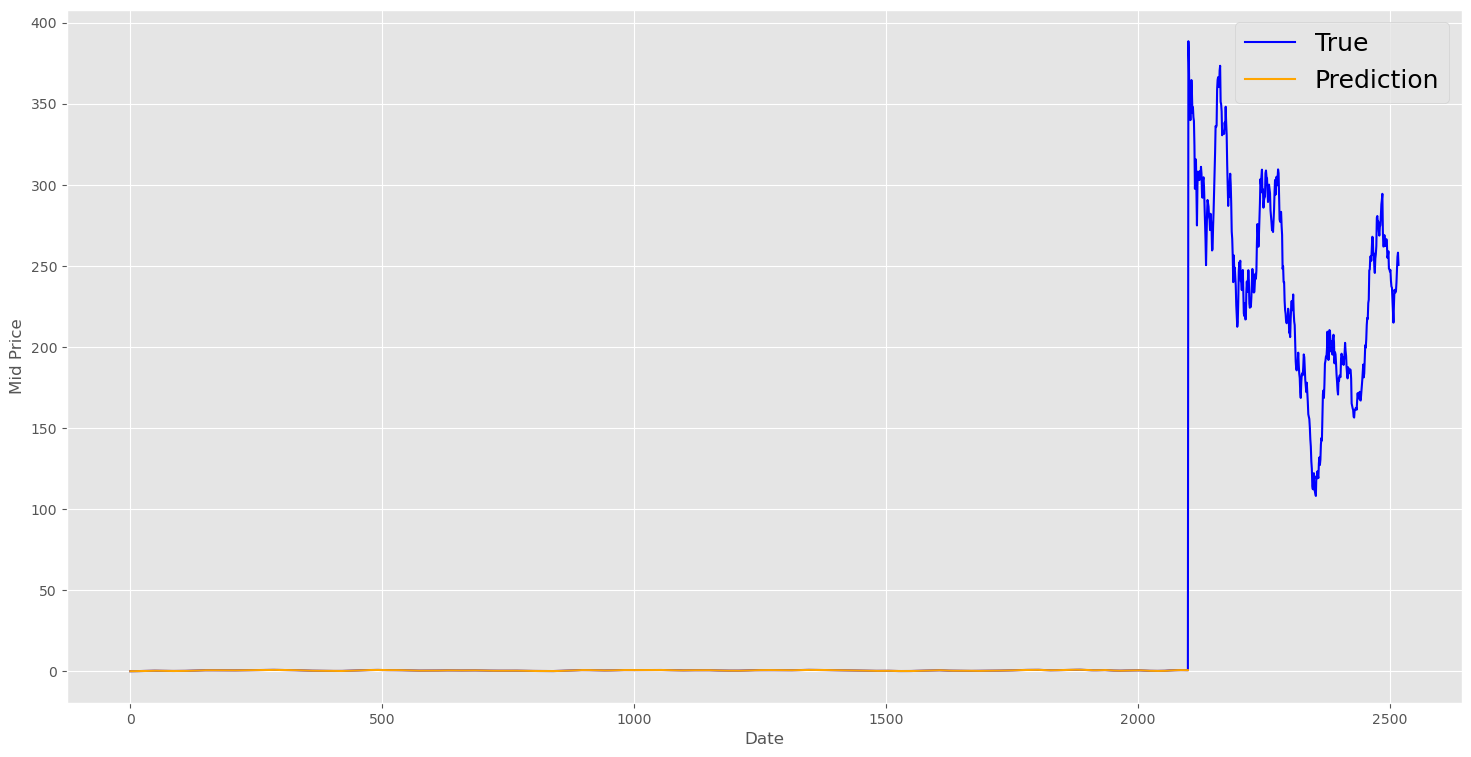

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

Introduction to LSTMs: Making Stock Movement Predictions Far into the Future

In [ ]:

# class DataGeneratorSeq(object):

#     def __init__(self,prices,batch_size,num_unroll):
#         self._prices = prices
#         self._prices_length = len(self._prices) - num_unroll
#         self._batch_size = batch_size
#         self._num_unroll = num_unroll
#         self._segments = self._prices_length //self._batch_size
#         self._cursor = [offset * self._segments for offset in range(self._batch_size)]

#     def next_batch(self):

#         batch_data = np.zeros((self._batch_size),dtype=np.float32)
#         batch_labels = np.zeros((self._batch_size),dtype=np.float32)

#         for b in range(self._batch_size):
#             if self._cursor[b]+1>=self._prices_length:
#                 #self._cursor[b] = b * self._segments
#                 self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

#             batch_data[b] = self._prices[self._cursor[b]]
#             batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

#             self._cursor[b] = (self._cursor[b]+1)%self._prices_length

#         return batch_data,batch_labels

#     def unroll_batches(self):

#         unroll_data,unroll_labels = [],[]
#         init_data, init_label = None,None
#         for ui in range(self._num_unroll):

#             data, labels = self.next_batch()    

#             unroll_data.append(data)
#             unroll_labels.append(labels)

#         return unroll_data, unroll_labels

#     def reset_indices(self):
#         for b in range(self._batch_size):
#             self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



# dg = DataGeneratorSeq(train_data,5,5)
# u_data, u_labels = dg.unroll_batches()

# for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
#     print('\n\nUnrolled index %d'%ui)
#     dat_ind = dat
#     lbl_ind = lbl
#     print('\tInputs: ',dat )
#     print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [3.0414420e-04 1.6229260e-01 9.7497307e-02 7.0530045e-01 2.0041822e-01]

	Output: [0.00257875 0.17359716 0.11786661 0.71075433 0.20041822]


Unrolled index 1
	Inputs:  [0.00111656 0.16762987 0.10178127 0.707424   0.20358567]

	Output: [0.00111656 0.16762987 0.12434145 0.71068394 0.21547401]


Unrolled index 2
	Inputs:  [0.00257875 0.17359716 0.10660312 0.7090746  0.206551  ]

	Output: [0.01550044 0.17359716 0.11786661 0.7102101  0.21848558]


Unrolled index 3
	Inputs:  [0.00475947 0.18010038 0.11196046 0.7102101  0.2095476 ]

	Output: [0.00475947 0.20282295 0.11786661 0.7102101  0.2095476 ]


Unrolled index 4
	Inputs:  [0.007651   0.18713206 0.11786661 0.71075433 0.21251689]

	Output: [0.01550044 0.21152663 0.13901654 0.70986915 0.21848558]


Defining Hyperparameters

In [ ]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.compat.v1.reset_default_graph() # This is important in case you run this multiple times

Defining Inputs and Outputs

In [ ]:
# tf.disable_v2_behavior()

# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [ ]:
lstm_cells = [
    # tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
    #                         state_is_tuple=True,
    #                         initializer= tf.contrib.layers.xavier_initializer()
    #                        )
    tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.initializers.GlorotUniform()
                           )
 for li in range(n_layers)]

# drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
#     lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
# ) for lstm in lstm_cells]
drop_lstm_cells = [tf.compat.v1.nn.rnn_cell.DropoutWrapper(
     lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
# drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
drop_multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(drop_lstm_cells)
# multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(lstm_cells)

# w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
w = tf.compat.v1.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.keras.initializers.GlorotUniform())
b = tf.compat.v1.get_variable('b',initializer=tf.random.uniform([1],-0.1,0.1))

C:\Users\thong.lam\AppData\Local\Temp\ipykernel_18408\554334990.py:6: UserWarning:

`tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.



ValueError: Variable w already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\tensorflow\python\framework\ops.py", line 3381, in _create_op_internal
    ret = Operation.from_node_def(
  File "c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\tensorflow\python\framework\op_def_library.py", line 795, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 2184, in variable_v2
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\tensorflow\python\ops\state_ops.py", line 70, in variable_op_v2
    return gen_state_ops.variable_v2(
  File "c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\tensorflow\python\ops\ref_variable.py", line 410, in _init_from_args
    self._variable = state_ops.variable_op_v2(


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [ ]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(train_data.shape, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=100,batch_size=32)

TypeError: Error converting shape to a TensorShape: Dimension value must be integer or None or have an __index__ method, got value '(2100,)' with type '<class 'tuple'>'.

In [ ]:
df

,date,open,high,low,close,adj close,volume
0,2013-09-03,11.560000,11.580000,11.093333,11.262667,11.262667,180916500.0
1,2013-09-04,11.318000,11.441333,11.037333,11.374667,11.374667,172135500.0
2,2013-09-05,11.340000,11.433333,11.216667,11.328667,11.328667,100279500.0
3,2013-09-06,11.238000,11.313333,11.010000,11.131333,11.131333,129295500.0
4,2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500.0
...,...,...,...,...,...,...,...
2513,2023-08-28,242.580002,244.380005,235.350006,238.820007,238.820007,107673700.0
2514,2023-08-29,238.580002,257.480011,237.770004,257.179993,257.179993,134047600.0
2515,2023-08-30,254.199997,260.510010,250.589996,256.899994,256.899994,121988400.0
2516,2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700.0


## Part 5. Calculating Support & Resistance in Python using K-Means Clustering

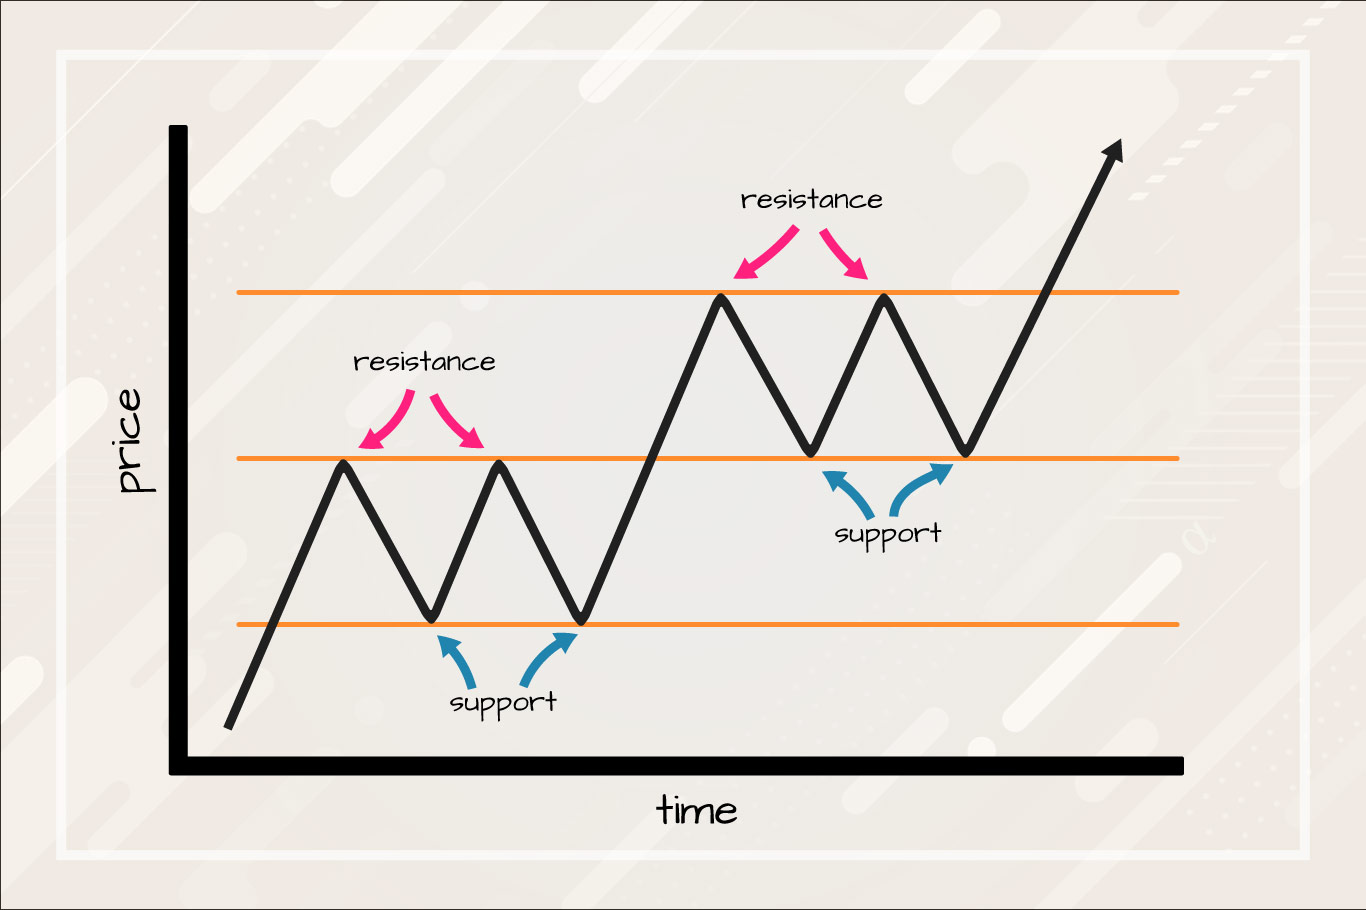

In [ ]:
df = df.set_index('date')

In [ ]:
from sklearn.cluster import KMeans

# Convert adjusted closing price to numpy array
symbol_prices = np.array(df["adj close"])
print("Symbol Prices:\n", symbol_prices)
# Perform cluster analysis
K = 6
kmeans = KMeans(n_clusters=6).fit(symbol_prices.reshape(-1, 1))
# predict which cluster each price is in
clusters = kmeans.predict(symbol_prices.reshape(-1, 1))
print("Clusters:\n", clusters)

Symbol Prices:
 [ 11.2626667   11.37466717  11.32866669 ... 256.8999939  258.07998657
 245.00999451]


c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Clusters:
 [0 0 0 ... 1 1 1]


In [ ]:
df

,open,high,low,close,adj close,volume
date,,,,,,
2013-09-03,11.560000,11.580000,11.093333,11.262667,11.262667,180916500.0
2013-09-04,11.318000,11.441333,11.037333,11.374667,11.374667,172135500.0
2013-09-05,11.340000,11.433333,11.216667,11.328667,11.328667,100279500.0
2013-09-06,11.238000,11.313333,11.010000,11.131333,11.131333,129295500.0
2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500.0
...,...,...,...,...,...,...
2023-08-28,242.580002,244.380005,235.350006,238.820007,238.820007,107673700.0
2023-08-29,238.580002,257.480011,237.770004,257.179993,257.179993,134047600.0
2023-08-30,254.199997,260.510010,250.589996,256.899994,256.899994,121988400.0


In [ ]:
import plotly.graph_objects as go

# Assigns plotly as visualization engine
pd.options.plotting.backend = 'plotly'
# Arbitrarily 6 colors for our 6 clusters
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo']
# Create Scatter plot, assigning each point a color based
# on it's grouping where group_number == index of color.
fig = df.plot.scatter(
    x=df.index,
    y="adj close",
    color=[colors[i] for i in clusters],
)
# Configure some styles
layout = go.Layout(
    plot_bgcolor='#efefef',
    showlegend=False,
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        ))
)
fig.update_layout(layout)
# Display plot in local browser window
fig.show()

Find Cluster Minimum & Maximum Values

In [ ]:
# Create list to hold values, initialized with infinite values
min_max_values = []
# init for each cluster group
for i in range(6):
    # Add values for which no price could be greater or less
    min_max_values.append([np.inf, -np.inf])
# Print initial values
print(min_max_values)
# Get min/max for each cluster
for i in range(len(symbol_prices)):
    # Get cluster assigned to price
    cluster = clusters[i]
    # Compare for min value
    if symbol_prices[i] < min_max_values[cluster][0]:
        min_max_values[cluster][0] = symbol_prices[i]
    # Compare for max value
    if symbol_prices[i] > min_max_values[cluster][1]:
        min_max_values[cluster][1] = symbol_prices[i]
# Print resulting values
print(min_max_values)

[[inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf]]
[[8.033332824707031, 71.98733520507812], [213.1000061035156, 260.5400085449219], [74.64199829101562, 157.6699981689453], [322.1366577148437, 409.9700012207031], [260.9166564941406, 319.5033264160156], [158.35000610351562, 211.8733367919922]]


In [ ]:
import plotly.graph_objects as go
# Again, assign an arbitrary color to each of the 6 clusters
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo']
# Create Scatter plot, assigning each point a color where
# point group = color index.
fig = df.plot.scatter(
    x=df.index,
    y="adj close",
    color=[colors[i] for i in clusters],
)

# fig = go.Figure(
#     data=go.Scatter(x=df.index,y=df['adj close'], mode='lines+markers')
#     # color=[colors[i] for i in clusters],
#     )
# Add horizontal lines
for cluster_min, cluster_max in min_max_values:
    fig.add_hline(y=cluster_min, line_width=1, line_color="blue")
    fig.add_hline(y=cluster_max, line_width=1, line_color="blue")
# Add a trace of the price for better clarity
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['adj close'],
    line_color="black",
    line_width=1
))
# Make it pretty
layout = go.Layout(
    plot_bgcolor='#efefef',
    showlegend=False,
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        ))
)
fig.update_layout(layout)
fig.show()

Consolidating Boundary Lines

In [ ]:
print("Initial Min/Max Values:\n", min_max_values)
# Create container for combined values
output = []
# Sort based on cluster minimum
s = sorted(min_max_values, key=lambda x: x[0])
# For each cluster get average of
for i, (_min, _max) in enumerate(s):
    # Append min from first cluster
    if i == 0:
        output.append(_min)
    # Append max from last cluster
    if i == len(min_max_values) - 1:
        output.append(_max)
    # Append average from cluster and adjacent for all others
    else:
        output.append(sum([_max, s[i+1][0]]) / 2)
print("Sorted Min/Max Values:\n", output)

Initial Min/Max Values:
 [[8.033332824707031, 71.98733520507812], [213.1000061035156, 260.5400085449219], [74.64199829101562, 157.6699981689453], [322.1366577148437, 409.9700012207031], [260.9166564941406, 319.5033264160156], [158.35000610351562, 211.8733367919922]]
Sorted Min/Max Values:
 [8.033332824707031, 73.31466674804688, 158.01000213623047, 212.4866714477539, 260.72833251953125, 320.8199920654297, 409.9700012207031]


In [ ]:
# Add horizontal lines
for cluster_avg in output:
    fig.add_hline(y=cluster_avg, line_width=1, line_color="blue")

In [ ]:
fig.show()

Assessing Absolute Minima/Maxima

In [ ]:
# Add horizontal lines 
for cluster_avg in output[1:-1]:
    fig.add_hline(y=cluster_avg, line_width=1, line_color="blue")

Determining the Right Number of Cluster

In [ ]:
# create a list to contain output values
values = []
# Define a range of cluster values to assess
K = range(1, 10)
# Performa a clustering using each value, save inertia_ value from each
for k in K:
    kmeans_n = KMeans(n_clusters=k)
    kmeans_n.fit(symbol_prices.reshape(-1, 1))
    values.append(kmeans_n.inertia_)


c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\thong.lam\AppData\Local\anacond

In [ ]:
import plotly.graph_objects as go
# Create initial figure
fig = go.Figure()
# Add line plot of inertia values
fig.add_trace(go.Trace(
    x=list(K),
    y=values,
    line_color="black",
    line_width=1
))
# Make it pretty
layout = go.Layout(
    plot_bgcolor='#efefef',
    showlegend=False,
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        ))
)
fig.update_layout(layout)
fig.show()

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\plotly\graph_objs\_deprecations.py:687: DeprecationWarning:

plotly.graph_objs.Trace is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




## LSTM

In [ ]:
df

,open,high,low,close,adj close,volume
date,,,,,,
2013-09-03,11.560000,11.580000,11.093333,11.262667,11.262667,180916500.0
2013-09-04,11.318000,11.441333,11.037333,11.374667,11.374667,172135500.0
2013-09-05,11.340000,11.433333,11.216667,11.328667,11.328667,100279500.0
2013-09-06,11.238000,11.313333,11.010000,11.131333,11.131333,129295500.0
2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500.0
...,...,...,...,...,...,...
2023-08-28,242.580002,244.380005,235.350006,238.820007,238.820007,107673700.0
2023-08-29,238.580002,257.480011,237.770004,257.179993,257.179993,134047600.0
2023-08-30,254.199997,260.510010,250.589996,256.899994,256.899994,121988400.0


In [ ]:
training_set = df.iloc[:1600, 1:2].values
test_set = df.iloc[1600:, 1:2].values

In [ ]:
print(training_set)

[[11.57999992]
 [11.44133282]
 [11.4333334 ]
 [11.31333256]
 [10.96666718]
 [11.16666698]
 [11.19333267]
 [11.11733341]
 [11.09133339]
 [11.39000034]
 [11.22799969]
 [11.16333294]
 [12.03133297]
 [12.38866711]
 [12.3653326 ]
 [12.33066654]
 [12.42000008]
 [12.64533329]
 [12.75199986]
 [12.96666718]
 [12.94866657]
 [12.78866673]
 [11.97933292]
 [12.07866669]
 [12.44866657]
 [12.39533329]
 [11.66600037]
 [11.71666718]
 [11.95266724]
 [12.16666698]
 [12.58600044]
 [12.48666668]
 [12.31999969]
 [12.39733315]
 [12.22599983]
 [11.85200024]
 [11.45400047]
 [11.63333321]
 [11.63333321]
 [11.36666679]
 [11.02999973]
 [11.17866707]
 [10.82933331]
 [11.06000042]
 [11.69266701]
 [12.0953331 ]
 [10.71533298]
 [ 9.71000004]
 [ 9.37333298]
 [ 9.69466686]
 [ 9.64666653]
 [ 9.49133301]
 [ 9.35999966]
 [ 9.19666672]
 [ 9.02999973]
 [ 8.60000038]
 [ 8.49666691]
 [ 8.31933308]
 [ 8.1833334 ]
 [ 8.38933277]
 [ 8.18133259]
 [ 8.46333313]
 [ 8.70600033]
 [ 8.56999969]
 [ 9.66266727]
 [ 9.62866688]
 [ 9.55666

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1600):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Train on 1540 samples
Epoch 1/100
1540/1540 [==============================] - 10s 7ms/sample - loss: 0.0188
Epoch 2/100
1540/1540 [==============================] - 8s 5ms/sample - loss: 0.0064
Epoch 3/100
1540/1540 [==============================] - 8s 5ms/sample - loss: 0.0061
Epoch 4/100
1540/1540 [==============================] - 8s 5ms/sample - loss: 0.0049
Epoch 5/100
1540/1540 [==============================] - 8s 5ms/sample - loss: 0.0048
Epoch 6/100
1540/1540 [==============================] - 8s 5ms/sample - loss: 0.0051
Epoch 7/100
1540/1540 [==============================] - 8s 5ms/sample - loss: 0.0043
Epoch 8/100
1540/1540 [==============================] - 7s 5ms/sample - loss: 0.0039
Epoch 9/100
1540/1540 [==============================] - 7s 4ms/sample - loss: 0.0039
Epoch 10/100
1540/1540 [==============================] - 6s 4ms/sample - loss: 0.0037
Epoch 11/100
1540/1540 [==============================] - 6s 4ms/sample - loss: 0.0031
Epoch 12/100
1540/1540 [=====

In [ ]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:1600, 1:2]
dataset_test = df.iloc[1600:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(459, 60, 1)


In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



In [ ]:
df = df.reset_index()

ValueError: x and y must have same first dimension, but have shapes (918,) and (459, 1)

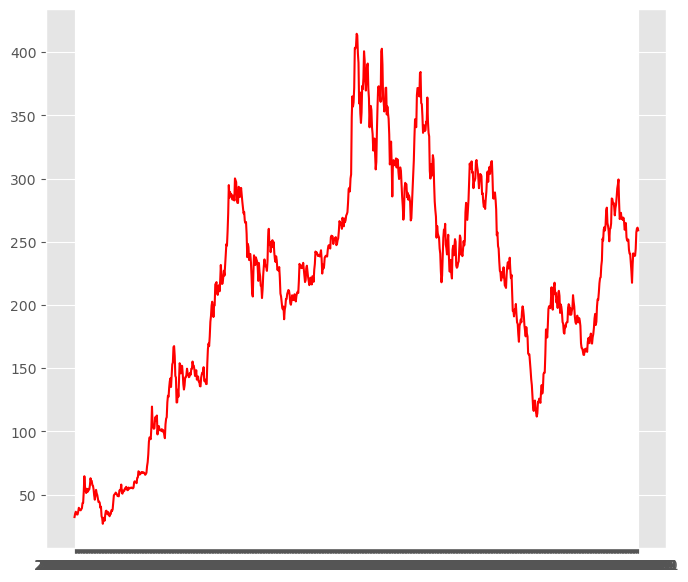

In [ ]:
# Visualising the results
plt.plot(df.loc[1600:, 'date'],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[1600:, 'date'],predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

## Classification: BUY OR SELL

## Conclusion